In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
# from scikeras.wrappers import KerasClassifier
from scikeras.wrappers import KerasClassifier
import joblib, os
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

INPUT_DIR = "../Output/proto_models_rev2_10000"
X_train_pad = joblib.load(os.path.join(INPUT_DIR, 'X_train_pad.pkl'))
X_test_pad = joblib.load(os.path.join(INPUT_DIR, 'X_test_pad.pkl'))

# Load data
df_train = pd.read_csv(os.path.join(INPUT_DIR, 'train_cleaned.csv'))
df_test = pd.read_csv(os.path.join(INPUT_DIR, 'test_cleaned.csv'))
# df_test = processor.load_data()

y_train = df_train['polarity']
y_test = df_test['polarity']

In [3]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [9]:
# CNN Model Construction
embedding_dim = 128  # Embedding layer dimension
max_features = 5000
max_leanth = 222
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_leanth))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification (0 or 1)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=early_stopping)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/10


/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6352 - loss: 0.6090 - val_accuracy: 0.8255 - val_loss: 0.3818
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9058 - loss: 0.2395 - val_accuracy: 0.8195 - val_loss: 0.4201
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9708 - loss: 0.0986 - val_accuracy: 0.8115 - val_loss: 0.5179
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9962 - loss: 0.0263 - val_accuracy: 0.8235 - val_loss: 0.6940
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.8308 - loss: 0.3606
Test Accuracy: 82.55%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Accuracy: 82.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       893
           1       0.83      0.87      0.85      1107

    accuracy                           0.83      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.83      0.82 

In [5]:
from tensorflow.keras.layers import Flatten

def create_cnn_model(filters=128, kernel_size=5, pool_size=2, dropout_rate=0.25, learning_rate=0.001, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_leanth))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))  # MaxPooling1D 사용
    model.add(Dropout(dropout_rate))
    model.add(Flatten())  # Flatten 추가
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (0 or 1)
    
    model.build(input_shape=(None, max_leanth))
    if optimizer == 'adam':
        selected_optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        selected_optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_cnn_model, epochs=10, batch_size=64, verbose=0, kernel_size=3, filters=128, pool_size=3, dropout_rate=0.25, learning_rate = 0.001)

# X_train_cnn = np.expand_dims(X_train_pad, axis=2)
# X_test_cnn = np.expand_dims(X_test_pad, axis=2)
model.fit(X_train_pad, y_train)
asd = model.predict(X_test_pad)

/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:

param_dist = {
    'filters': [128, 256],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],               
    'dropout_rate': [0.25, 0.5, 0.75],    
    'learning_rate': [0.0005, 0.001],  
    'batch_size': [64],    
    'epochs': [3],
    'optimizer': ['adam', 'rmsprop'],               
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=2, cv=2, verbose=1, n_jobs=1, random_state=42)

random_search_result = random_search.fit(X_train_pad, y_train)

print(f"Best parameters found: {random_search_result.best_params_}")
print(f"Best accuracy: {(random_search_result.best_score_ * 100):.2f}%")

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning: ``build

Best parameters found: {'pool_size': 2, 'optimizer': 'adam', 'learning_rate': 0.0005, 'kernel_size': 3, 'filters': 256, 'epochs': 3, 'dropout_rate': 0.75, 'batch_size': 64}
Best accuracy: 81.78%


In [8]:
y_pred_prob = random_search_result.best_estimator_.predict(X_test_pad)

y_pred = (y_pred_prob > 0.5).astype("int32")

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 83.05%
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81       893
           1       0.83      0.87      0.85      1107

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [42]:

y_pred = (asd > 0.5).astype("int32")

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 78.70%
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78       893
           1       0.85      0.75      0.80      1107

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [ ]:

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

In [14]:
random_search_result.best_params_

{'optimizer': 'rmsprop',
 'kernel_size': 3,
 'filters': 128,
 'epochs': 3,
 'batch_size': 64}

In [17]:
best_params = random_search_result.best_params_

param_grid = {
    # 'model__filters': [int(best_params['model__filters']*0.5),best_params['model__filters'],int(best_params['model__filters']*2)],
    # 'model__kernel_size': [best_params['model__kernel_size']],
    # 'model__pool_size': [best_params['model__pool_size']],
    # 'model__dropout_rate': [best_params['model__dropout_rate']*0.5, best_params['model__dropout_rate'], best_params['model__dropout_rate']*2],
    # 'model__learning_rate': [best_params['model__learning_rate'] * 0.5, best_params['model__learning_rate'], best_params['model__learning_rate'] * 2],
    # 'batch_size': [best_params['batch_size']],
    # 'epochs': [best_params['epochs']]
    
    'filters': [int(best_params['filters']*0.5),best_params['filters'],int(best_params['filters']*2)],
    'kernel_size': [best_params['kernel_size']],
    'optimizer': [best_params['optimizer']],
    # 'model__pool_size': [best_params['model__pool_size']],
    # 'model__dropout_rate': [best_params['model__dropout_rate']*0.5, best_params['model__dropout_rate'], best_params['model__dropout_rate']*2],
    # 'model__learning_rate': [best_params['model__learning_rate'] * 0.5, best_params['model__learning_rate'], best_params['model__learning_rate'] * 2],
    'batch_size': [best_params['batch_size'],best_params['batch_size']*2],
    'epochs': [best_params['epochs']]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
    n_jobs=1
)

X_train_cnn = np.expand_dims(X_train_pad, axis=2)

grid_search_result = grid_search.fit(X_train_cnn, y_train)

print(f"Best parameters found by GridSearchCV: {grid_search_result.best_params_}")
print(f"Best accuracy from GridSearchCV: {grid_search_result.best_score_:.2f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found by GridSearchCV: {'batch_size': 128, 'epochs': 3, 'filters': 128, 'kernel_size': 3, 'optimizer': 'rmsprop'}
Best accuracy from GridSearchCV: 0.83


In [18]:
y_pred_prob = grid_search_result.best_estimator_.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

63/63 [==============================] - 0s 1ms/step
Model Accuracy: 82.50%
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78       893
           1       0.80      0.92      0.85      1107

    accuracy                           0.82      2000
   macro avg       0.84      0.81      0.82      2000
weighted avg       0.83      0.82      0.82      2000



In [19]:
best_params_path = os.path.join(INPUT_DIR, 'cnn_best_params.pkl')
best_model_path = os.path.join(INPUT_DIR, 'cnn_best_model.pkl')
grid_search_path = os.path.join(INPUT_DIR, 'cnn_grid_search.pkl')

with open(best_params_path, 'wb') as file:
    pickle.dump(grid_search.best_params_, file)

with open(best_model_path, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

with open(grid_search_path, 'wb') as file:
    pickle.dump(grid_search, file)

print("Best parameters, model, and GridSearchCV object have been saved.")


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
......global_max_pooling1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-10-12 21:17:10         2545
metadata.json                                  2024-10-12 21:17:10           64
variables.h5                                   2024-10-12 21:17:10      5673536
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layer

In [25]:
# Best parameters from GridSearchCV
best_params = grid_search_result.best_params_
print(best_params)

# Reshape X_train_pad and X_test_pad to add channel dimension
X_train_cnn = np.expand_dims(X_train_pad, axis=2)
X_test_cnn = np.expand_dims(X_test_pad, axis=2)

searched_model = Sequential()
searched_model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_leanth))
searched_model.add(Conv1D(filters=best_params['filters'], kernel_size=best_params['kernel_size'], activation='relu'))
searched_model.add(GlobalMaxPooling1D())
searched_model.add(Dense(128, activation='relu'))
searched_model.add(Dense(1, activation='sigmoid'))  # Binary classification (0 or 1)

# Compile the model with the optimal learning rate
searched_model.compile(optimizer=best_params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = searched_model.fit(X_train_cnn, y_train, epochs=10, 
                   batch_size=best_params['batch_size'], 
                   callbacks=[early_stopping], 
                   validation_data=(X_test_cnn, y_test))

# Predict on the test set
y_pred_prob = searched_model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))


{'batch_size': 128, 'epochs': 3, 'filters': 128, 'kernel_size': 3, 'optimizer': 'rmsprop'}
Epoch 1/10
79/79 [==============================] - 3s 34ms/step - loss: 0.6276 - accuracy: 0.6454 - val_loss: 0.5213 - val_accuracy: 0.7405
Epoch 2/10
79/79 [==============================] - 2s 23ms/step - loss: 0.3905 - accuracy: 0.8281 - val_loss: 0.3954 - val_accuracy: 0.8260
Epoch 3/10
79/79 [==============================] - 1s 16ms/step - loss: 0.2726 - accuracy: 0.8926 - val_loss: 0.4629 - val_accuracy: 0.7875
Epoch 4/10
79/79 [==============================] - 1s 14ms/step - loss: 0.1962 - accuracy: 0.9310 - val_loss: 0.4210 - val_accuracy: 0.8230
Epoch 5/10
63/63 [==============================] - 0s 1ms/step
Model Accuracy: 82.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       893
           1       0.82      0.87      0.85      1107

    accuracy                           0.83      2000
   macro avg    

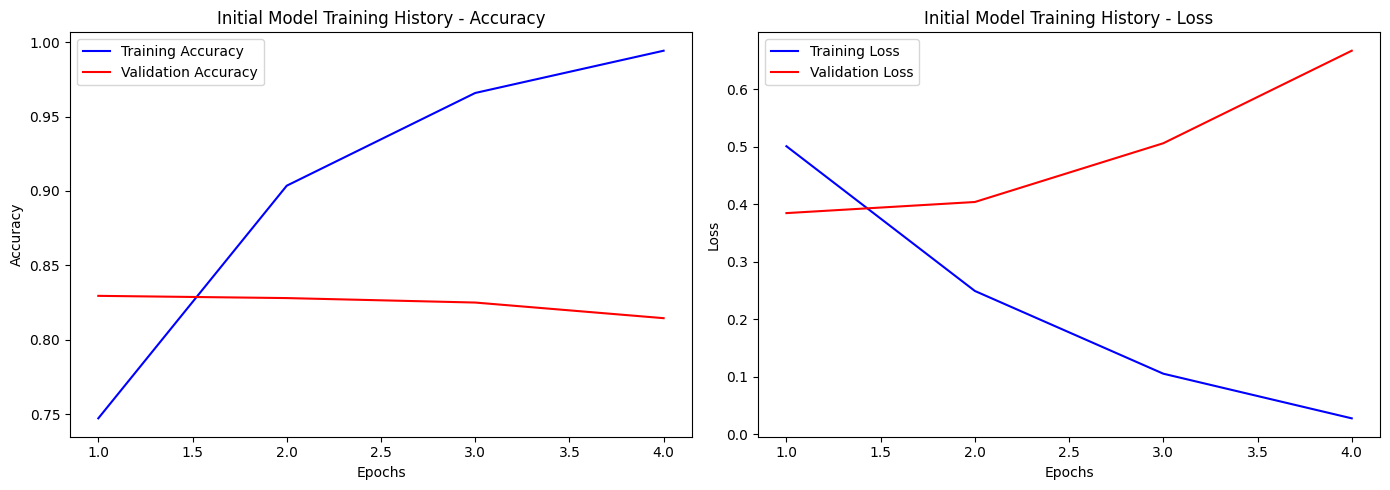

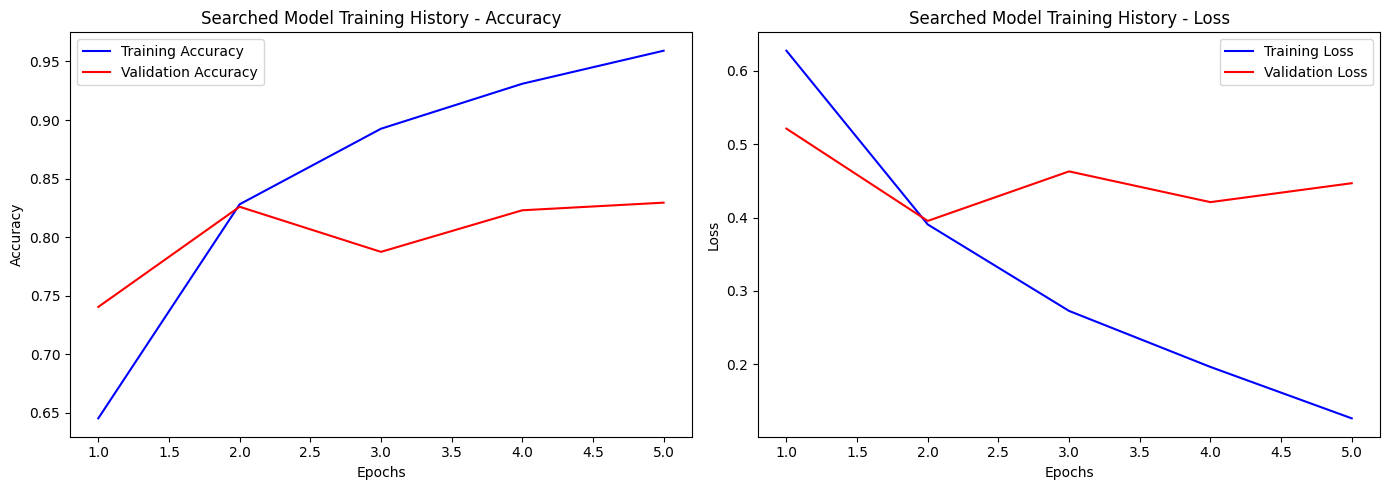

In [26]:
import matplotlib.pyplot as plt

# Define a function to plot training history
def plot_training_history(history, title="Model Training History"):
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for hist
plot_training_history(hist, title="Initial Model Training History")

# Plot for history
plot_training_history(history, title="Searched Model Training History")